In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pdb
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow.python.ops import parallel_for as pfor
import sys
import json
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy import stats
from numpy import linalg as LA
from sklearn import linear_model
from sklearn.manifold import MDS
from sklearn.neighbors import DistanceMetric
from scipy.spatial import distance
from sklearn.cluster import KMeans

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from tools_lnd import get_T_inds, plot_FP, plot_N, TDR_axes, out_axes, plot_FP_jitter, make_FP_axs, comp_eig_decomp
from tools_lnd import make_axes, same_stim_trial, generate_Beta_epoch, take_names, gen_X_from_model_dir_epoch
from tools_lnd import make_h_trial_rule, get_model_params, gen_trials_from_model_dir, gen_X_from_model_dir

In [2]:
figpath = os.path.join(p,'code','overleaf','multitask-nets','v2_figs','find_sing_fps')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [226]:
##################################################################
#Find right model dir
##################################################################

rule_trains = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
          'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
          'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

rule_trains_str = '_'.join(rule_trains)

rnn_type = 'LeakyRNN'
activation = 'retanh'
w_init = 'diag'
n_tasks = str(len(rule_trains))
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
seed = 'untrained'
net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
data_folder = 'data/rnn/multitask/stepnet/variable_stim'

m = os.path.join(p,data_folder,rnn_type,activation,w_init,n_tasks+'_tasks',n_rnn+'_n_rnn',net_name,seed)

r1 = 18
r2 = 19
task_list = [rules_dict['all'][r1],rules_dict['all'][r2]]
epoch_list = ['stim1','stim1']

t_set = [0,0]

<IPython.core.display.Javascript object>


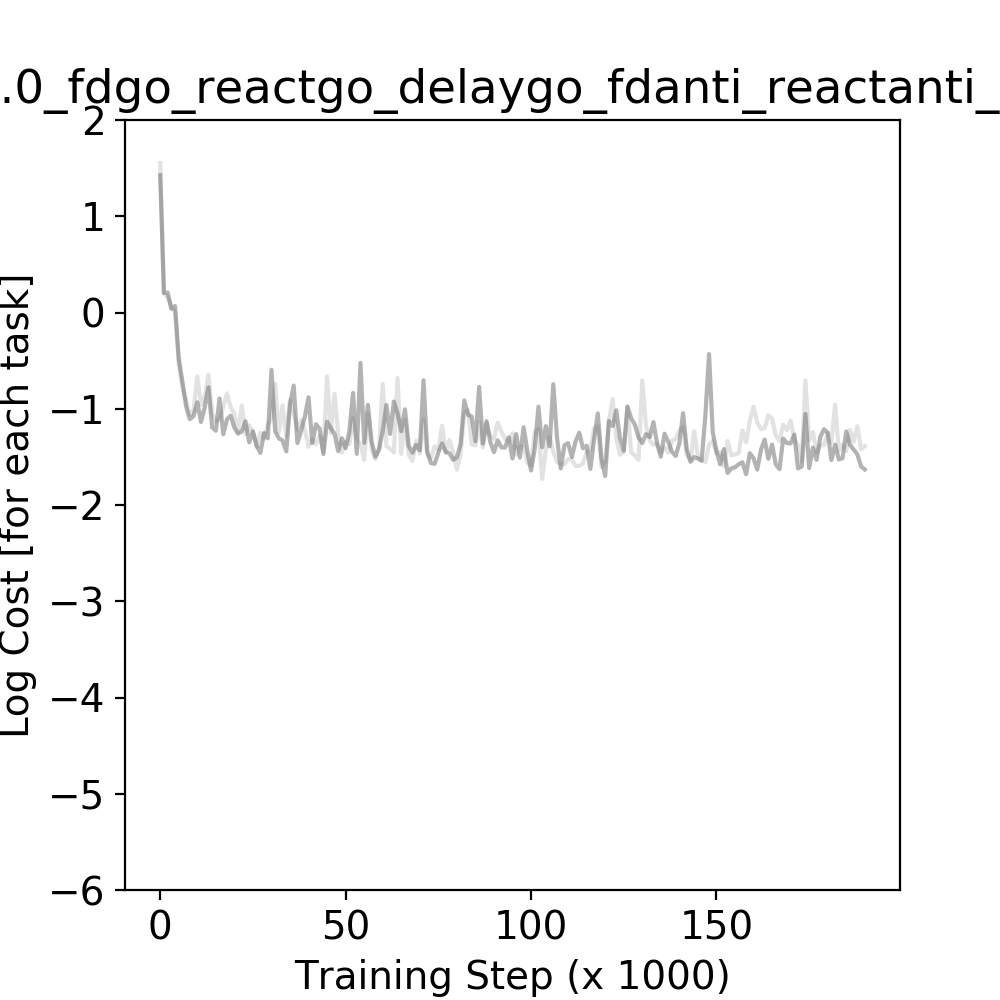

In [227]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = np.log(log_all['cost_'+task_list[r]])
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Log Cost [for each task]')
    plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

<IPython.core.display.Javascript object>


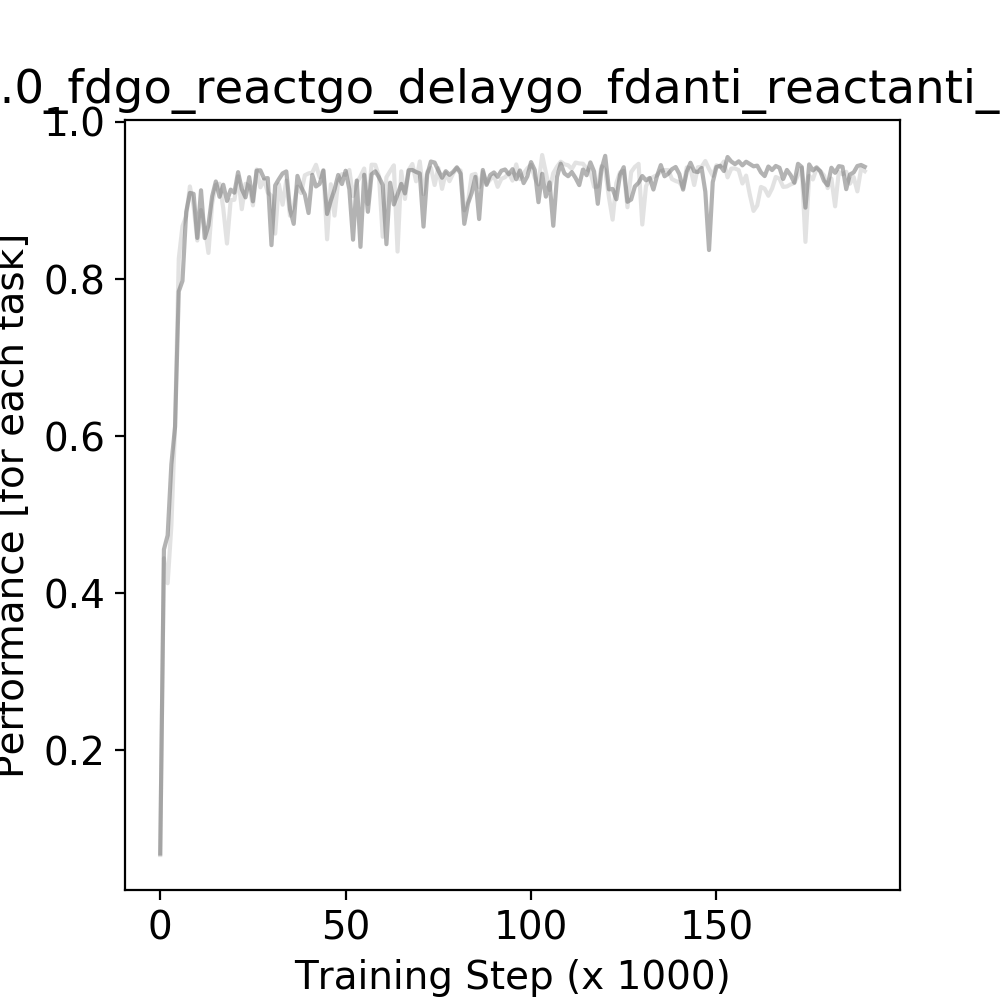

In [228]:
fig = plt.figure(figsize=(5, 5))
cmap=plt.get_cmap('Greys')
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)
for r in range(len(task_list)):
    c = cmap((r+1)/(len(task_list)+1))
    ax = fig.add_subplot(1,1,1)
    x = log_all['perf_'+task_list[r]]
    plt.plot(x,'-',c = c,alpha = .5)
    ax.set_xlabel('Training Step (x 1000)')
    ax.set_ylabel('Performance [for each task]')
#     plt.ylim([-6,2])
    
plt.title(m)
plt.show()    

In [229]:
model = Model(m)
rule = task_list[0]
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

def relu(x):
    f = x * (x > 0)
    return f

def rnn_vanilla(params, h, x, alpha):
    alpha = .2
    xh = np.concatenate([x,h], axis=0)
    gate_inputs = np.dot(params[0].T,xh)+params[1]
    noise = 0
    output = _activation(gate_inputs) # + noise
    
#     print(type(alpha),type(h),type(output))

    h_new = (1-alpha) * h + alpha * output
    
    return h_new

def vanilla_run_with_h0(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(np.expand_dims(h0,axis=1))
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))

    h_t = np.squeeze(np.array(h_t))  
    return h_t

def vanilla_run_at_fp(params, x_t, h0, alpha):
    h = h0
    h_t = []
    h_t.append(h)
    for x in x_t:
        h = rnn_vanilla(params, np.squeeze(h), np.squeeze(x.T), alpha)
        h_t.append(np.expand_dims(h,axis=1))
        
    return h_t

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt


In [230]:
rule = task_list[0]
fp_epoch = 'stim1'

model = FixedPoint_Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    hparams = model.hp
    alpha = hparams['dt']/hparams['tau']
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]

    trial = generate_trials(rule, hparams, mode='test',noise_on=False)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    T,S,N = np.shape(h_tf)
    T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt


In [231]:
from tools_lnd import make_h_all
rule = task_list[0]
e_name = 'stim1'
trial = generate_trials(rule, hparams, 'test', noise_on=False)
h_all_byepoch, h_all_byrule = make_h_all(m)
X_use = h_all_byrule[rule]

from sklearn.decomposition import PCA
pca = PCA(n_components = 10)
fp_pca = pca.fit_transform(np.reshape(X_use[:],(-1,hparams['n_rnn'])))
D_use = pca.components_.T

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt


/Users/lauradriscoll/Documents/code/multitask-nets/stepnet/task.py:147: RuntimeWarning: invalid value encountered in multiply
  self.stim_strength = 100*np.empty((len(locs),4))


<IPython.core.display.Javascript object>


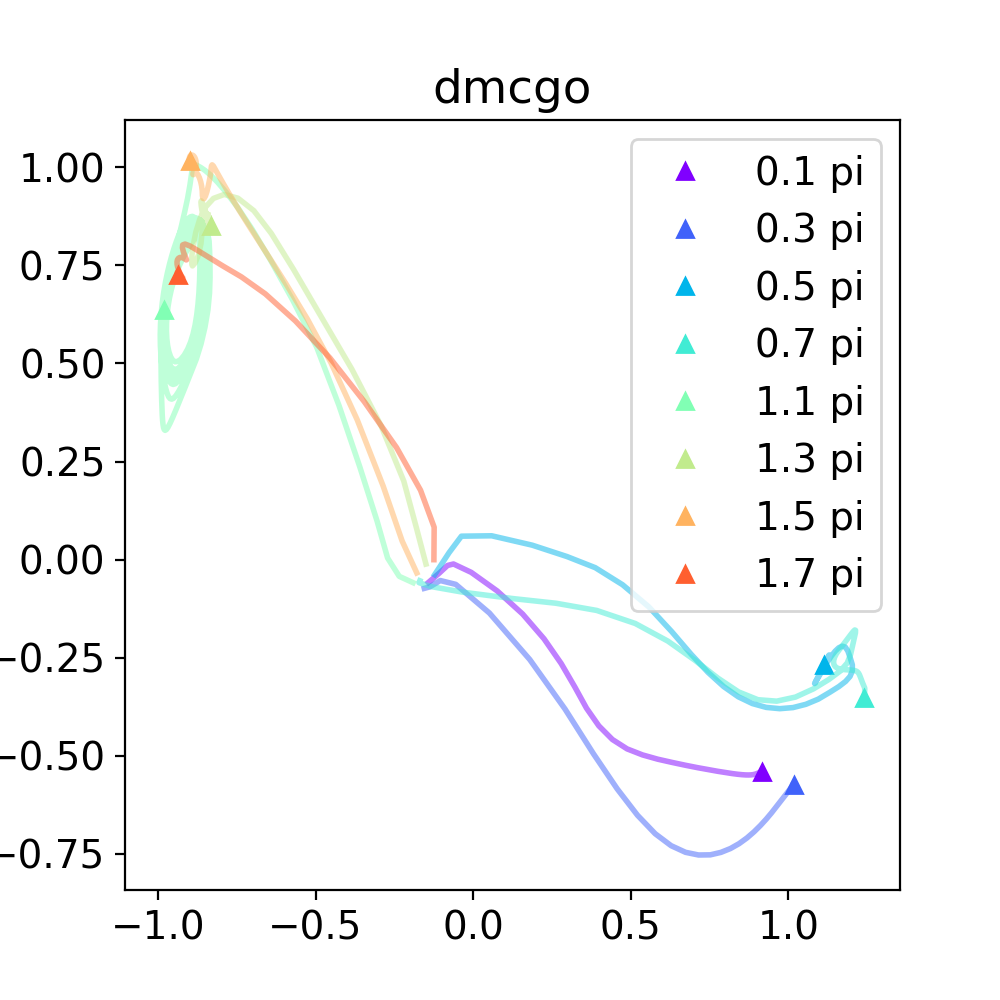

In [232]:
fig = plt.figure(figsize=(5, 5))
ti = 0
n_steps = 5000
cmap = plt.get_cmap('rainbow')

for ti in range(0,np.shape(X_use)[1],10):
    trial_label = str(round(np.min(trial.stim_locs[ti,:])/np.pi,1))+ ' pi'
    
    h0 = X_use[T_inds[0],ti,:]
    x_t = np.matlib.repmat(trial.x[T_inds[0],ti,:],n_steps,1)
    h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
    
    jitter = np.dot(h_t,D_use)
    plt.plot(jitter[-1,0],jitter[-1,1],'^',c = cmap(ti/80),linewidth = 3,label = trial_label)
    plt.plot(jitter[:,0],jitter[:,1],'-',c = cmap(ti/80),linewidth = 2,alpha = .5)
    
plt.title(rule)
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


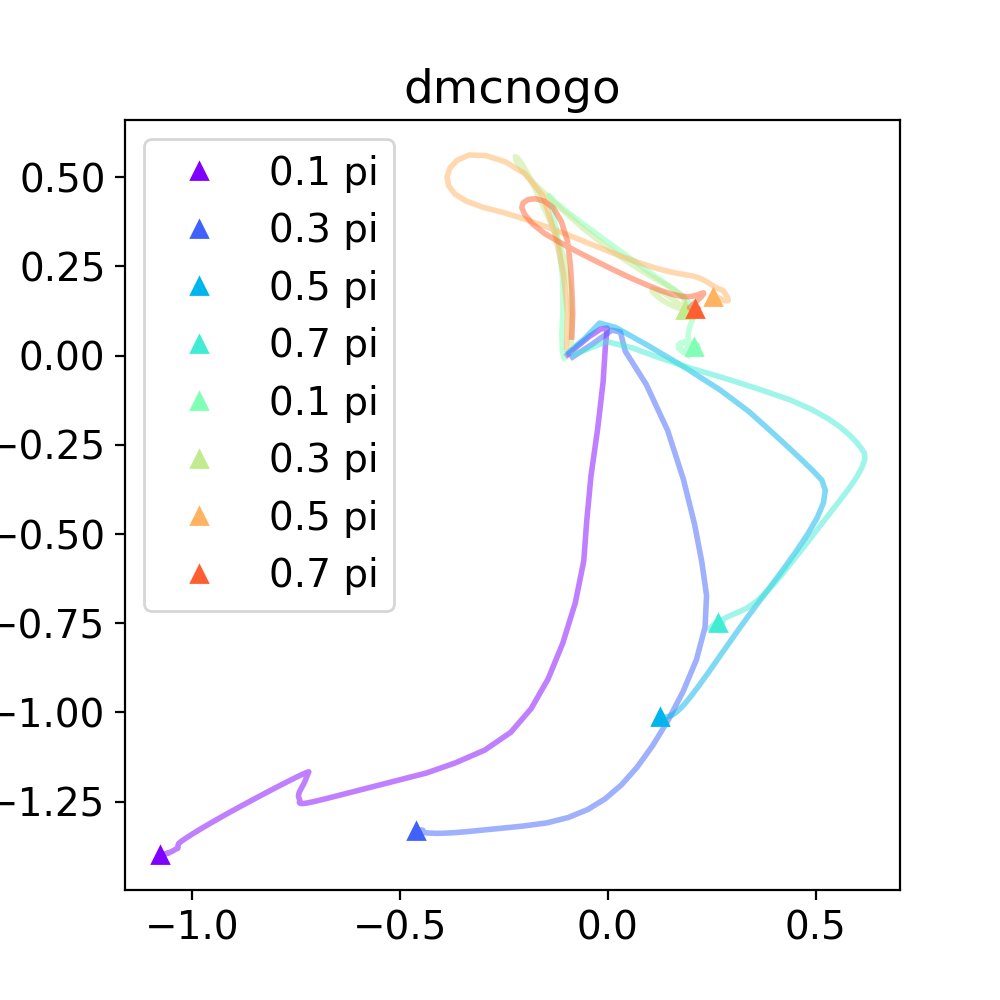

In [233]:
rule = task_list[1]
trial = generate_trials(rule, hparams, 'test', noise_on=False)
X_use = h_all_byrule[rule]

fig = plt.figure(figsize=(5, 5))
ti = 0
n_steps = 5000
cmap = plt.get_cmap('rainbow')

for ti in range(0,np.shape(X_use)[1],10):
    trial_label = str(round(np.min(trial.stim_locs[ti,:])/np.pi,1))+ ' pi'
    
    h0 = X_use[T_inds[0],ti,:]
    x_t = np.matlib.repmat(trial.x[T_inds[0],ti,:],n_steps,1)
    h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
    
    jitter = np.dot(h_t,D_use)
    plt.plot(jitter[-1,0],jitter[-1,1],'^',c = cmap(ti/80),linewidth = 3,label = trial_label)
    plt.plot(jitter[:,0],jitter[:,1],'-',c = cmap(ti/80),linewidth = 2,alpha = .5)
    
plt.title(rule)
plt.legend()
plt.show()

In [234]:
def plot_FP_jitter(m,D_use,rule_master,t_num,fp_epoch,sorted_fps,fp_inds,eig_decomps,rule_set,
                   xlabel = 'FP set PC1',ylabel = 'FP set PC2',rand_step_coef = 0.1,n_steps = 100,
                   lw = 3,al = .6,linestyle = '-',n_jit = 0,c_master = 'k',lesion_units = []):

    cmap=plt.get_cmap('rainbow')
        
    model = FixedPoint_Model(m)
    with tf.Session() as sess:
        model.restore()
        if len(lesion_units)>0:
            model.lesion_units(sess, lesion_units)
        model._sigma=0
        hparams = model.hp
        alpha = hparams['dt']/hparams['tau']
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        for rule in rule_set:
            trial = generate_trials(rule, hparams, mode='test',noise_on=False)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            T,S,N = np.shape(h_tf)
            T_inds = get_T_inds(trial,fp_epoch) # grab epoch time indexing

#             for s in range(0,S,int(S/8)):

#                 if c_master == 'y_locs':
#                     c_inds = trial.y_loc[-1,:]
#                     c = cmap(c_inds[s]/(2*np.pi))
#                 elif c_master == 'x_locs':
#                     stim1_locs = np.min(trial.stim_locs[:,[0,2]],axis=1)
#                     c = cmap(stim1_locs[s]/(2*np.pi))
#                 else:
#                     c = c_master

#                 X_trial = np.dot(h_tf[T_inds,s,:],D_use)
#                 plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = al, linewidth = lw)
#                 plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = al, linewidth = lw)
#                 plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = al, linewidth = lw)

        trial = generate_trials(rule_master, hparams, mode='test',noise_on=False)
        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf = sess.run(model.h, feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T_inds = get_T_inds(trial,fp_epoch)

        if c_master == 'y_locs':
            c_inds = trial.y_loc[-1,:]
            c = cmap(c_inds[t_num]/(2*np.pi))
        elif c_master == 'x_locs':
            stim1_locs = np.min(trial.stim_locs,axis=1)
            c = cmap(stim1_locs[t_num]/(2*np.pi))
        else:
            c = c_master

        X_trial = np.dot(h_tf[T_inds,t_num,:],D_use)
        plt.plot(X_trial[0,0],X_trial[0,1],'x',c = c, alpha = .8, linewidth = 5)
        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, alpha = .8, linewidth = 5)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, alpha = .8, linewidth = 5, markersize = 10)

        for fp_ind in fp_inds:

            if np.max(eig_decomps[fp_ind]['evals'])>.99:
                markerfacecolor = 'None'

            else:
                markerfacecolor = c

            x_t = np.matlib.repmat(trial.x[T_inds[0],t_num,:],n_steps,1)
            for jit in range(n_jit):
                h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
                h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
                jitter = np.dot(h_t,D_use)
                plt.plot(jitter[-1,0],jitter[-1,1],'^k',linewidth = .1,alpha = .1)
                plt.plot(jitter[:,0],jitter[:,1],'-k',linewidth = .1)

            fp = np.dot(sorted_fps[fp_ind,:],D_use)
            # print(np.shape(fp))
            plt.plot(fp[0],fp[1],'o',c = c,linewidth = 5,markersize = 3,markerfacecolor = markerfacecolor)

            h_t = vanilla_run_with_h0(params, x_t, h_tf[T_inds[0],t_num,:], hparams)
            jitter = np.dot(h_t,D_use)
            plt.plot(jitter[-1,0],jitter[-1,1],'^k',c = c)
            plt.plot(jitter[:,0],jitter[:,1],'-k',c = c,linewidth = 1)
            plt.plot(jitter[0,0],jitter[0,1],'xk',c = c,linewidth = 5,markersize = 10)

        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(rule_master)

In [235]:
def plot_FP_jitter_3D(m,D_use,trial,t_num,fp_epoch,fp_struct,fp_inds,x_t,jit_fps=False,compute_stabiility = True,
                   rand_step_coef = 0.1,n_steps = 100,lw = 3,al = .6,linestyle = '-',n_jit = 0,c = 'k'):
    
    sorted_fps = fp_struct['xstar'][fp_inds,:]
    
    if compute_stabiility == True:
        J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
        eig_decomps = comp_eig_decomp(J_xstar)

    cmap=plt.get_cmap('rainbow')
        
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        model._sigma=0
        hparams = model.hp
        
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]

        feed_dict = tools.gen_feed_dict(model, trial, hparams)
        h_tf, _ = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
        T,S,N = np.shape(h_tf)
        
        if jit_fps==True:
            for fp_ind in range(len(sorted_fps)):
                for jit in range(n_jit):
                    h0 = sorted_fps[fp_ind,:] + rand_step_coef*npr.randn(N)
                    h_t = vanilla_run_with_h0(params, x_t, h0, hparams)
                    jitter = np.dot(h_t,D_use)
                    ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = 'k',linewidth = .1)
                    
                    if compute_stabiility == True:
                    
                        X_trial = np.dot(sorted_fps[fp_ind,:],D_use)

                        if np.max(eig_decomps[fp_ind]['evals'].real)<1:
                            al = .8
                            s= 30
                            c_temp = c
                        else:
                            al = .2
                            s = 10
                            c_temp = c

                        ax.scatter(X_trial[0], X_trial[1], X_trial[2], 'o', c = c_temp, s = s, alpha = al)
                
        
        for jit in range(1):
            h0 = h_tf[T_inds[0],t_num,:]
            h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
            jitter = np.dot(h_t,D_use)
            ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,linewidth = 3)

In [236]:
def plot_N(X, D, clist, linewidth = 1, alpha = .5, linestyle = '-', cmap_c = 'hsv',markersize = 10):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap(cmap_c)
    S = np.shape(X)[0]
    
    for s in range(S):

        if len(clist)==1:
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        plt.plot(X_trial[-1,0],X_trial[-1,1],'^',c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
        plt.plot(X_trial[:,0],X_trial[:,1],linestyle,c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)
        plt.plot(X_trial[0,0],X_trial[0,1],'o',c = c, linewidth = linewidth, alpha = alpha, markersize = markersize)

In [237]:
def get_interp_filename(trial1,trial2,epoch_list,t_set):
    n_stim_per_ring = int(np.shape(trial1.y)[2]-1)
    stim_size = int(2*n_stim_per_ring+1)

    rule1 = rules_dict['all'][np.argmax(trial1.x[0,0,stim_size:])]
    rule2 = rules_dict['all'][np.argmax(trial2.x[0,0,stim_size:])]
    ind_stim_loc1  = 180*trial1.y_loc[-1,t_set[0]]/np.pi
    ind_stim_loc2  = 180*trial2.y_loc[-1,t_set[1]]/np.pi
    filename = rule1+'_'+rule2+'_'+'_'.join(epoch_list)+'_x'+str(round(ind_stim_loc1,2))+'_x'+str(round(ind_stim_loc2,2))

    return filename

In [238]:
def get_single_task_fp_filename(trial, epoch,t):
    ind_stim_loc  = str(int(180*trial.y_loc[-1,t]/np.pi))
    nonzero_stim = trial.stim_locs[t,:]<100
    stim_names = '_'.join(str(int(180*x/np.pi)) for x in trial.stim_locs[t,nonzero_stim])
    filename = epoch+'_trial'+str(t)+'_x'+stim_names+'_y'+ind_stim_loc

    return filename

In [16]:
%matplotlib notebook

<IPython.core.display.Javascript object>


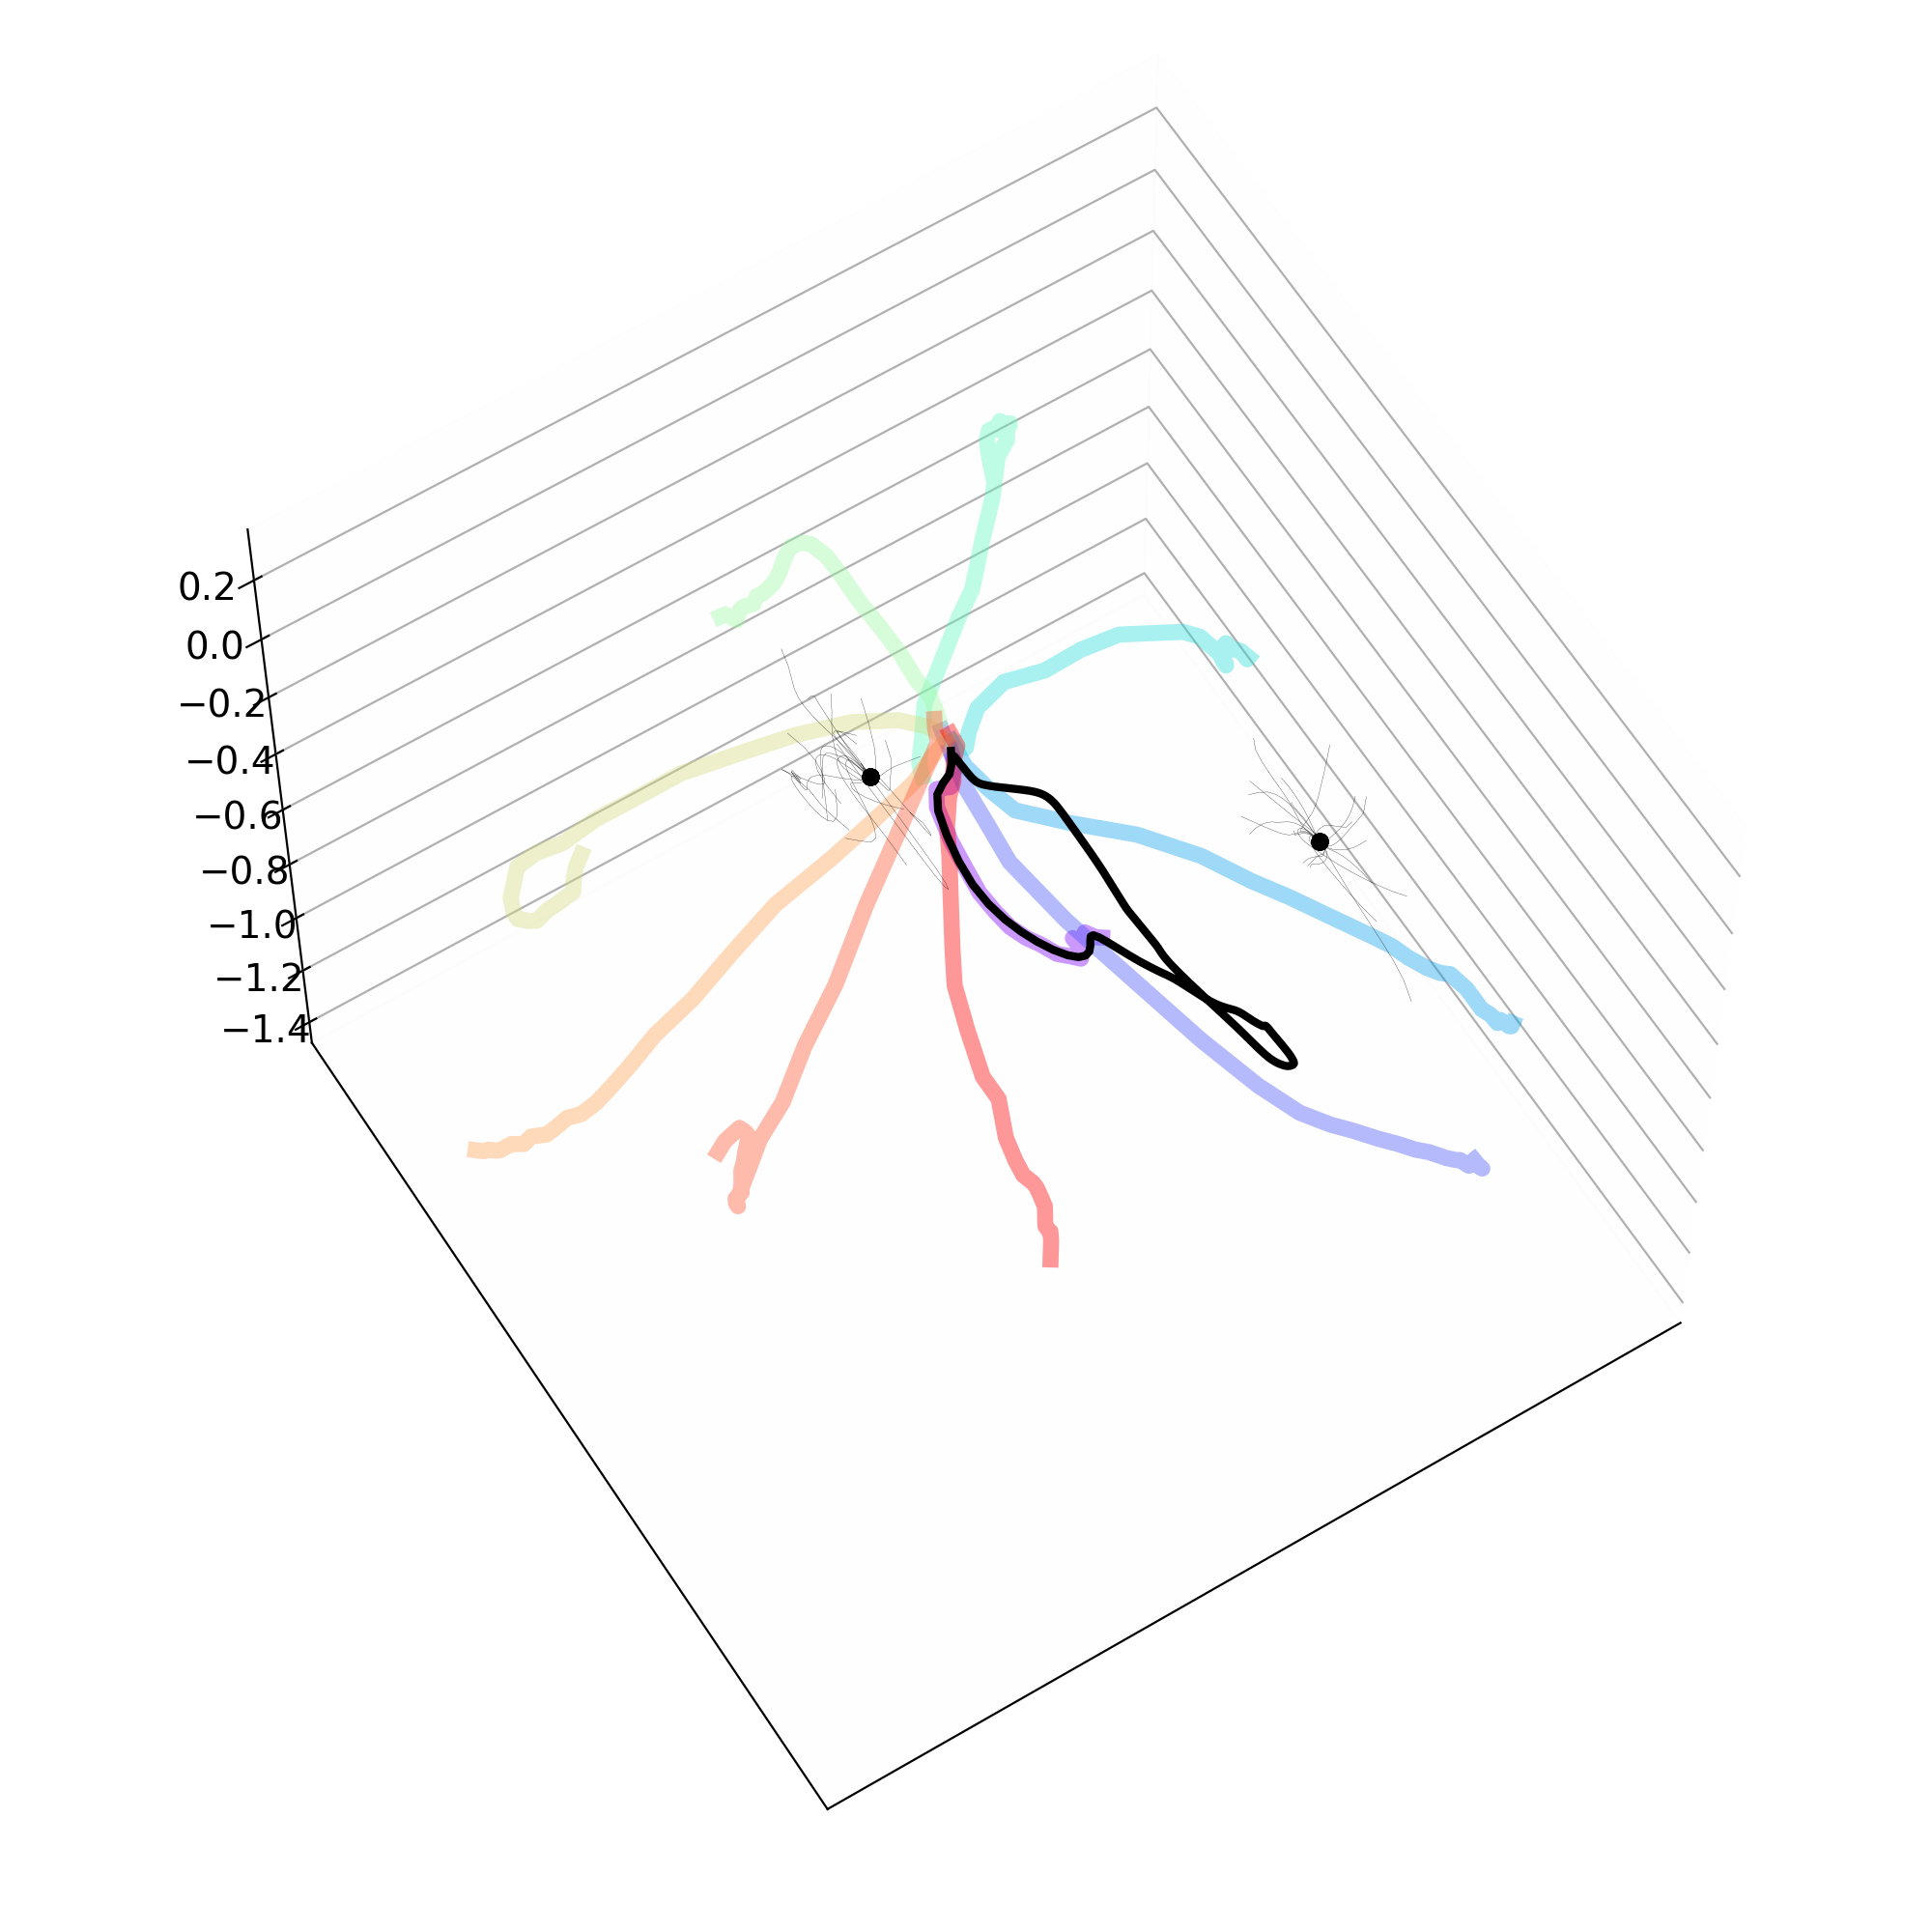

stim1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
0.158113883008419
Variables bein

In [248]:
########## X TASK ###########
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
from tools_lnd import plot_N3D
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

trial_num = 0
r1 = 16
rule = rules_dict['all'][r1]
epoch = 'stim1'
axs = 'pca_fp'
c = 'orchid'
linestyle = '-'
q_thresh = 5e-8

epoch_name, rule_name, _, _ = take_names(epoch,rule)
axes_label1 = axs+' 1'
axes_label2 = axs+' 2'
axes_label3 = axs+' 3'

rand_step_coef = 0
al = .3
n_steps = 500

ax = fig.add_subplot(111, projection='3d')
w_color = .005
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule)
f = get_single_task_fp_filename(trial,epoch,trial_num)
filename = os.path.join(save_dir,f+'.npz')
fp_struct = np.load(filename)

# D_use = make_FP_axs(filename, m, rule, epoch, axs = axs, clust = 'False')

_,x = gen_X_from_model_dir(m,trial)
T_inds = get_T_inds(trial,epoch)
x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
x_t = np.matlib.repmat(trial.x[T_inds[1],trial_num,:],n_steps,1)

plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 6, 
       linestyle = linestyle, alpha = .4)

fp_inds = fp_struct['qstar'] < q_thresh
plot_FP_jitter_3D(m,D_use,trial,trial_num,epoch,fp_struct,fp_inds,x_t,jit_fps=True,
                  rand_step_coef = 0.1,n_steps = n_steps,lw = 3,al = .3,linestyle = '-',n_jit = 20,
                  c = 'k')

# tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('')
ax.view_init(elev=61, azim=-122)
plt.show()

In [138]:
def plot_h_interp_input(ax, h0, x_t, D_use, params, hparams, lw = 3, al = .6, 
                        linestyle = '-',c = 'k', dim3 = 'True'):
    
    alpha = hparams['dt']/hparams['tau']
    h_t = vanilla_run_with_h0(params, x_t, h0, alpha)
    jitter = np.dot(h_t,D_use)
    
    if dim3 == 'True':
        ax.plot3D(jitter[:,0],jitter[:,1],jitter[:,2],'-',c = c,linewidth = lw,alpha = al)
    else:
        ax.plot(jitter[:,0],jitter[:,1],'-',c = c,linewidth = lw,alpha = al)

In [168]:
D_use = D_use[:,1:]

In [187]:
trial = gen_trials_from_model_dir(m,'delaydm1',mode='test',noise_on = False)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt


In [191]:
trial.stim_strength[:,0]

array([0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  ,
       1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75,
       1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 ,
       0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25,
       0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  ,
       1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75,
       1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 ,
       0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25,
       0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  ,
       1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75,
       1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 ,
       0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25,
       0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.  ,
       1.25, 0.5 , 0.75, 1.  , 1.25, 0.5 , 0.75, 1.

<IPython.core.display.Javascript object>


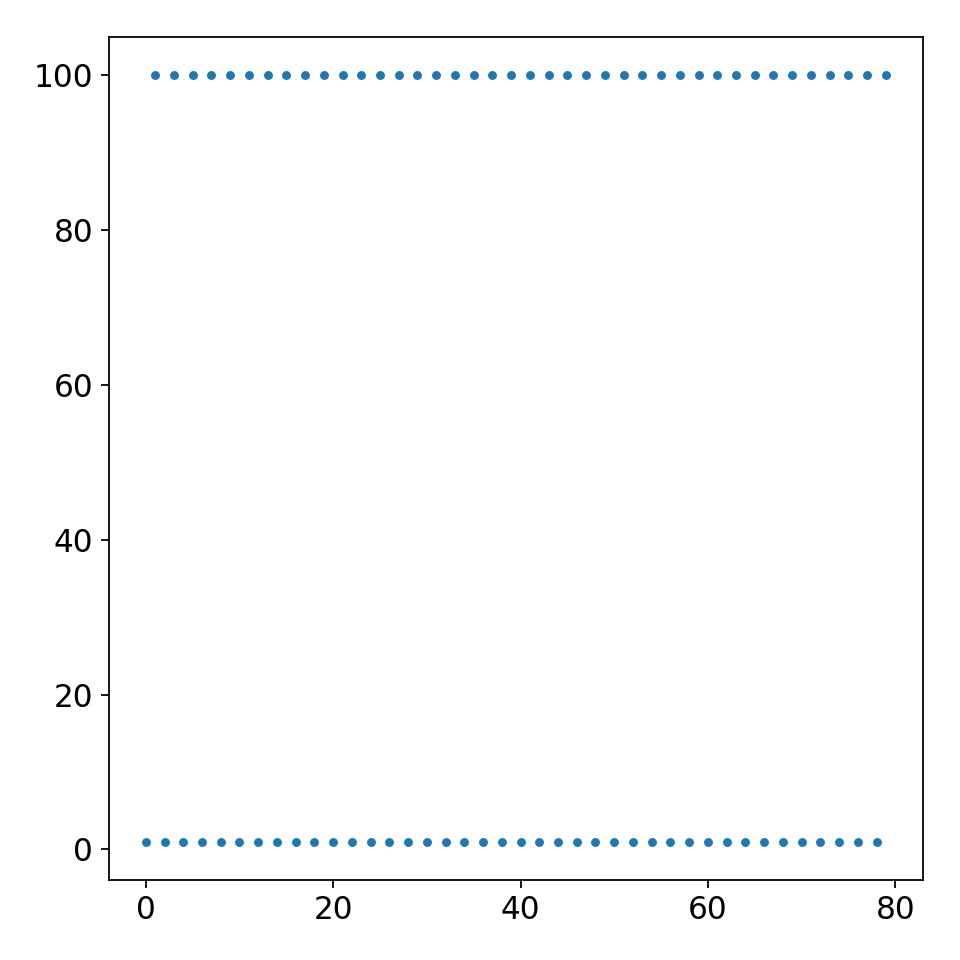

In [185]:
fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
plt.plot(trial.stim_strength[:,0],'.')
plt.show()

In [202]:
big_stim_trials

(array([   8,    9,   10, ..., 3197, 3198, 3199]),)

In [216]:
rules_dict['all'][17]

'dmsnogo'

<IPython.core.display.Javascript object>


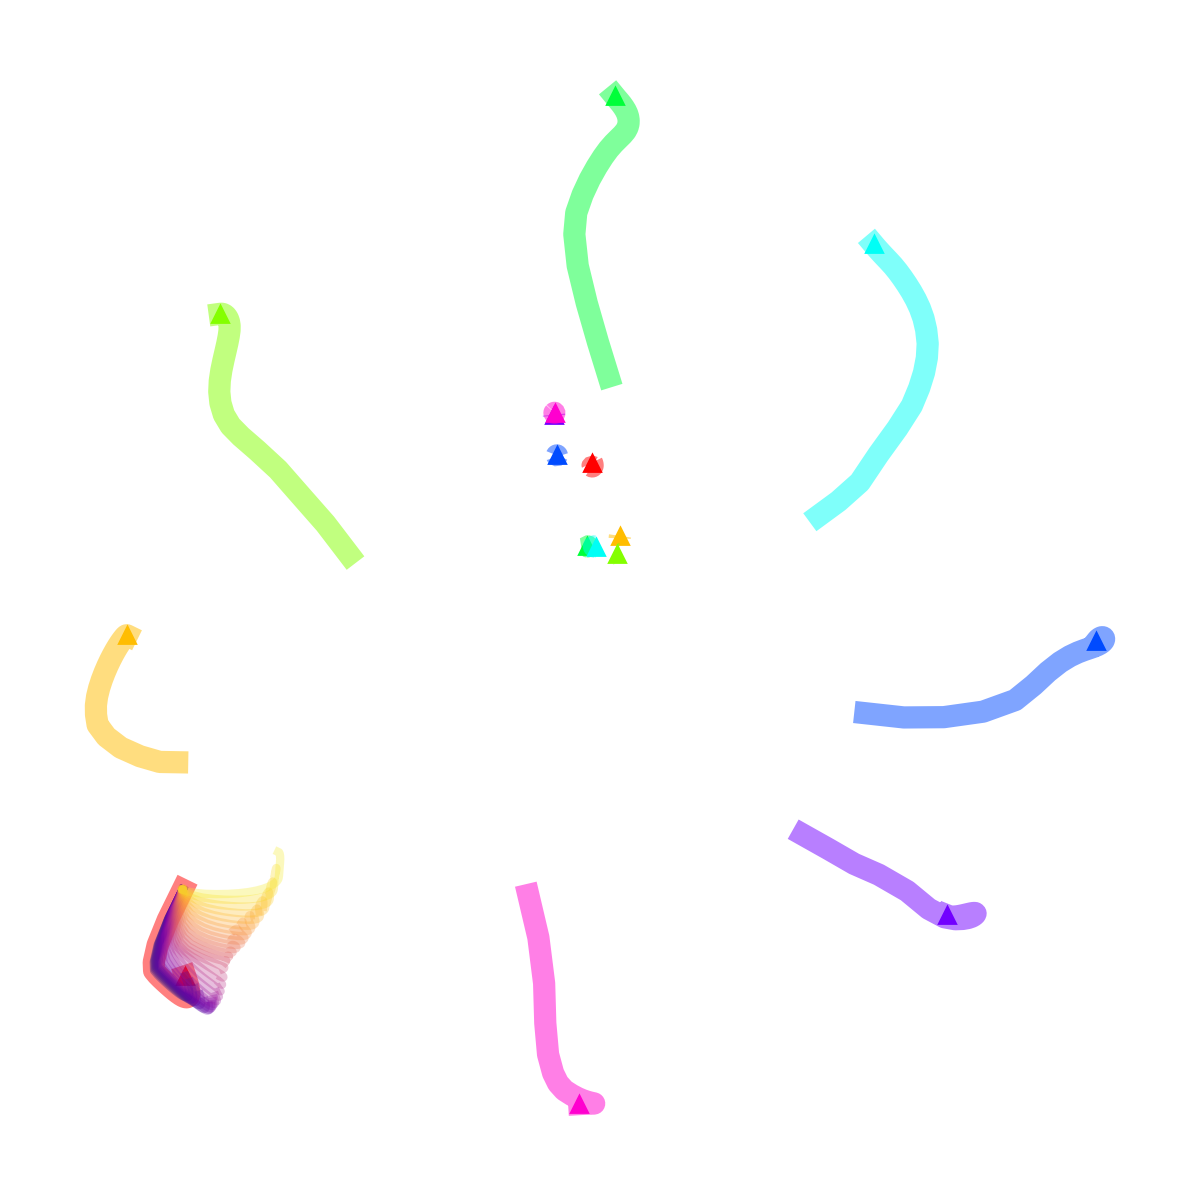

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
0.158113883008419
Variables being opti

In [240]:
########## X TASK ###########
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
ax = fig.add_subplot(111)


epoch_list = ['go1','go1']
axs = 'pca_h'
cmap_grad = plt.get_cmap('plasma')
cmap_stim = plt.get_cmap('hsv')
c_discrete = [cmap_grad(0),cmap_grad(1)]
linestyle = ['-',':']
ri_set = [3,1]
n_interp = 30
n_steps = 25
n_trials = 8
trial_num = [0,0]
epoch = epoch_list[0]

D_use = make_FP_axs(filename, m, rules_dict['all'][ri_set[0]], epoch, axs = axs, clust = 'False')

epoch_name, rule_name1, _, _ = take_names(epoch,rules_dict['all'][ri_set[0]])
_, rule_name2, _, _ = take_names(epoch,rules_dict['all'][ri_set[1]])
axes_label1 = axs+' 1'
axes_label2 = axs+' 2'

rule1 = rules_dict['all'][ri_set[0]]
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, ri_set[1]) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

trial_set = [trial1,trial2]

T_inds1 = get_T_inds(trial1,epoch_list[0])
inputs_1 = trial1.x[T_inds1[1],trial_num[0],:]

T_inds2 = get_T_inds(trial2,epoch_list[1])
inputs_2 = trial2.x[T_inds2[1],trial_num[1],:]

del_inputs = inputs_2 - inputs_1

for ri in [1,0]:
    rule = rules_dict['all'][ri_set[ri]]
    trial = trial_set[ri]
    
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    h_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    
    big_stim_trials = np.where(trial.stim_strength[:,0]>.99)[0]
    
    for ti_ind in range(0,len(big_stim_trials),int(len(big_stim_trials)/n_trials)):
        ti = big_stim_trials[ti_ind]
        
        trial_label = str(round(np.min(trial.stim_locs[ti,:])/np.pi,1))+ ' pi'

        h0 = h_epoch[ti,0,:]
        x_t = np.matlib.repmat(trial.x[T_inds[0],ti,:],n_steps,1)
        h_t = vanilla_run_with_h0(params, x_t, h0, hparams)

        jitter = np.dot(h_t,D_use)
        plt.plot(jitter[-1,0],jitter[-1,1],'^',c = cmap_stim(ti/np.shape(x)[1]),
                 linewidth = 8,label = trial_label)
        plt.plot(jitter[:,0],jitter[:,1],c = cmap_stim(ti/np.shape(x)[1]),
                 linewidth = 8,alpha = .5, linestyle = linestyle[ri])
#         plt.plot(jitter[:,0],jitter[:,1],'-',c = c_discrete[ri],linewidth = 3,alpha = .5)

for step_i in range(n_interp):
    
    step_inputs = inputs_1[np.newaxis,:]+del_inputs[np.newaxis,:]*(step_i/n_interp)
    x_t = np.matlib.repmat(step_inputs,n_steps,1)
    h0 = h_epoch[trial_num[ri],0,:]
    
    plot_h_interp_input(ax, h0, x_t, D_use, params, hparams, lw = 3, al = .3, 
                        linestyle = '-',c = cmap_grad(step_i/n_interp), dim3 = 'False')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('')

tasks_str = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])
if not os.path.exists(os.path.join(figpath,step_file,tasks_str)):
    os.makedirs(os.path.join(figpath,step_file,tasks_str))
    
figname = axes_label1+'_'+axes_label2+'_'+axes_label3+'_'+epoch+'_'+tasks_str
plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.png'))
plt.show()

<IPython.core.display.Javascript object>


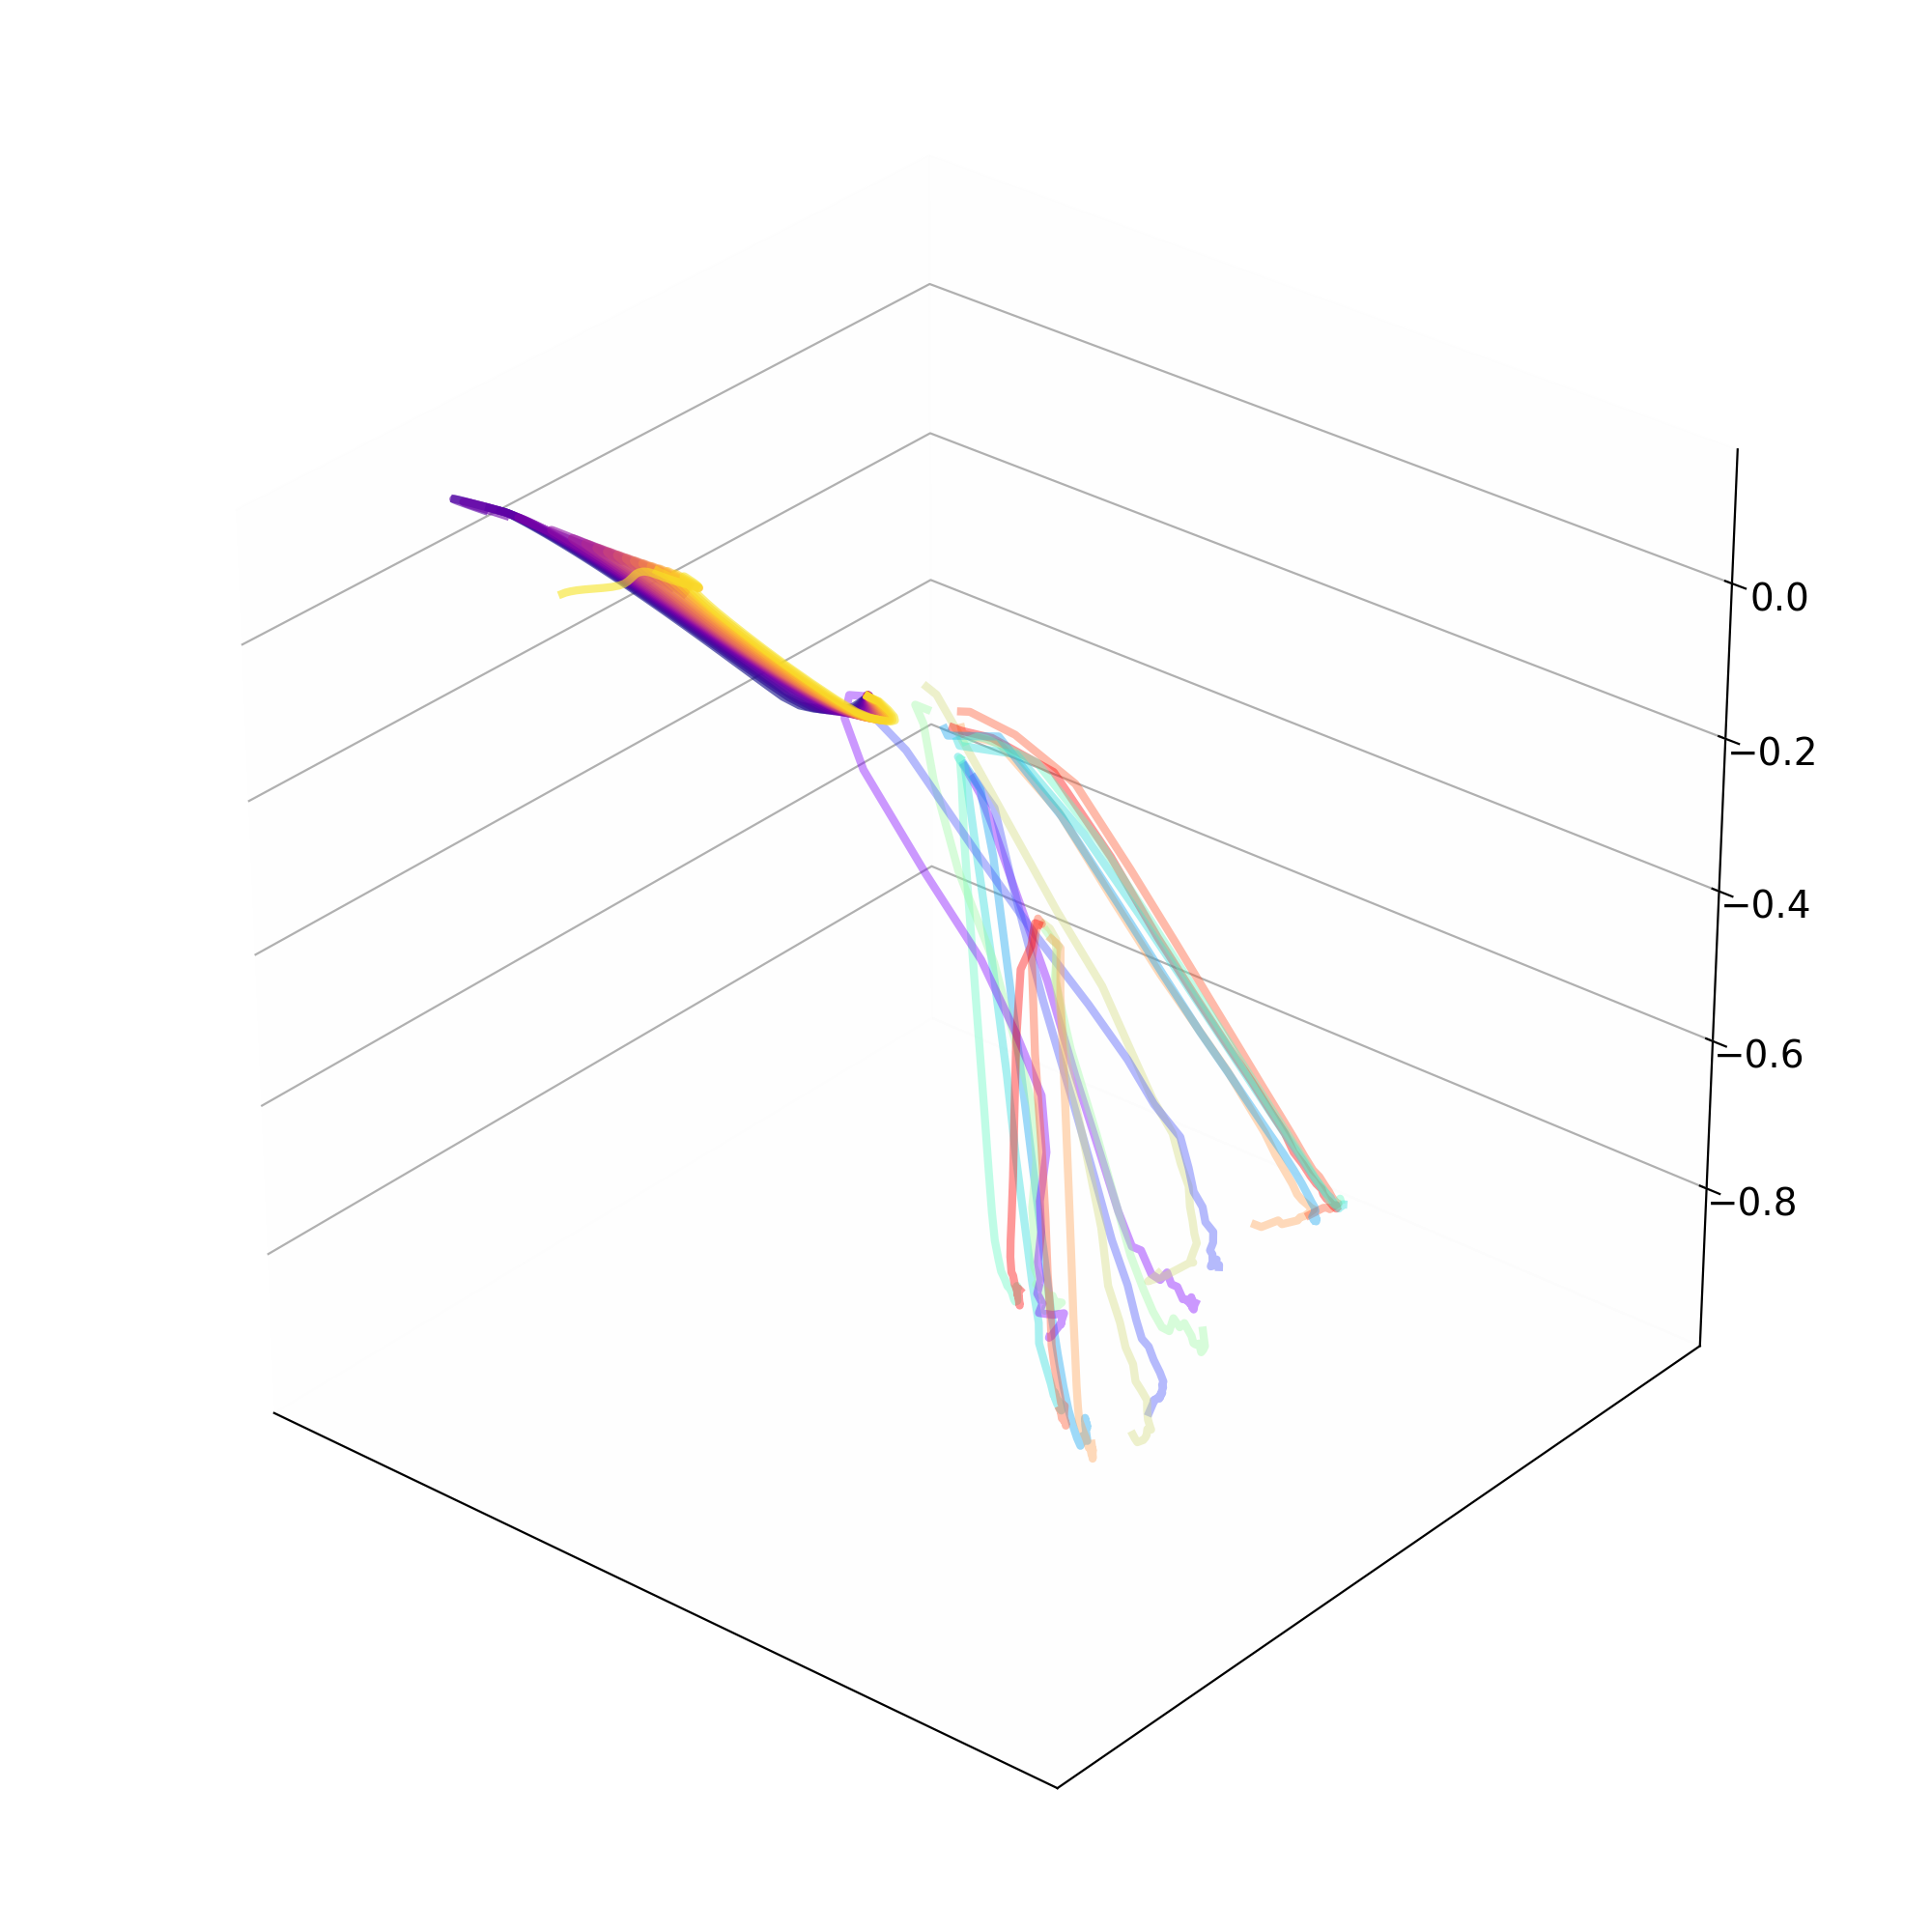

go1
go1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
0.158113883008419
Variables be

In [241]:
########## X TASK ###########
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

ax = fig.add_subplot(111, projection='3d')
w_color = .005
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

trial_num = [0,0]
epoch_list = ['stim1','stim1']
axs = 'pca_h'
c = 'orchid'
cmap_grad = plt.get_cmap('plasma')
step_file = 'interp_tasks'
q_tol_name = 'tol_q_e_7.0'
linestyle = '-'
q_thresh = 1e-7
ri_set = [19,18]
n_interp = 20
n_steps = 100

# D_use = make_FP_axs(filename, m, rule, epoch, axs = axs, clust = 'False')

epoch_name, rule_name1, _, _ = take_names(epoch,rules_dict['all'][ri_set[0]])
_, rule_name2, _, _ = take_names(epoch,rules_dict['all'][ri_set[1]])
axes_label1 = axs+' 1'
axes_label2 = axs+' 2'
axes_label3 = axs+' 3'

rule1 = rules_dict['all'][ri_set[0]]
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, ri_set[1]) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

T_inds1 = get_T_inds(trial1,epoch_list[0])
inputs_1 = trial1.x[T_inds1[1],trial_num[0],:]
T_inds2 = get_T_inds(trial2,epoch_list[1])
inputs_2 = trial2.x[T_inds2[1],trial_num[1],:]
del_inputs = inputs_2 - inputs_1

for ri in [1,0]:
    rule = rules_dict['all'][ri_set[ri]]
    trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
    trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,trial_set,linewidth = 3, 
           linestyle = linestyle, alpha = .4)
    

for step_i in range(n_interp):
    
    step_inputs = inputs_1[np.newaxis,:]+del_inputs[np.newaxis,:]*(step_i/n_interp)
    x_t = np.matlib.repmat(step_inputs,n_steps,1)
    h0 = x_epoch[trial_num[ri],0,:]
    
    plot_h_interp_input(ax, h0, x_t, D_use, params, hparams, lw = 3, al = .6, 
                        linestyle = '-',c = cmap_grad(step_i/n_interp))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('')
ax.view_init(elev=30, azim=-50)

tasks_str = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])
if not os.path.exists(os.path.join(figpath,step_file,tasks_str)):
    os.makedirs(os.path.join(figpath,step_file,tasks_str))
    
figname = axes_label1+'_'+axes_label2+'_'+axes_label3+'_'+epoch+'_'+tasks_str
plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.png'))
plt.show()

<IPython.core.display.Javascript object>


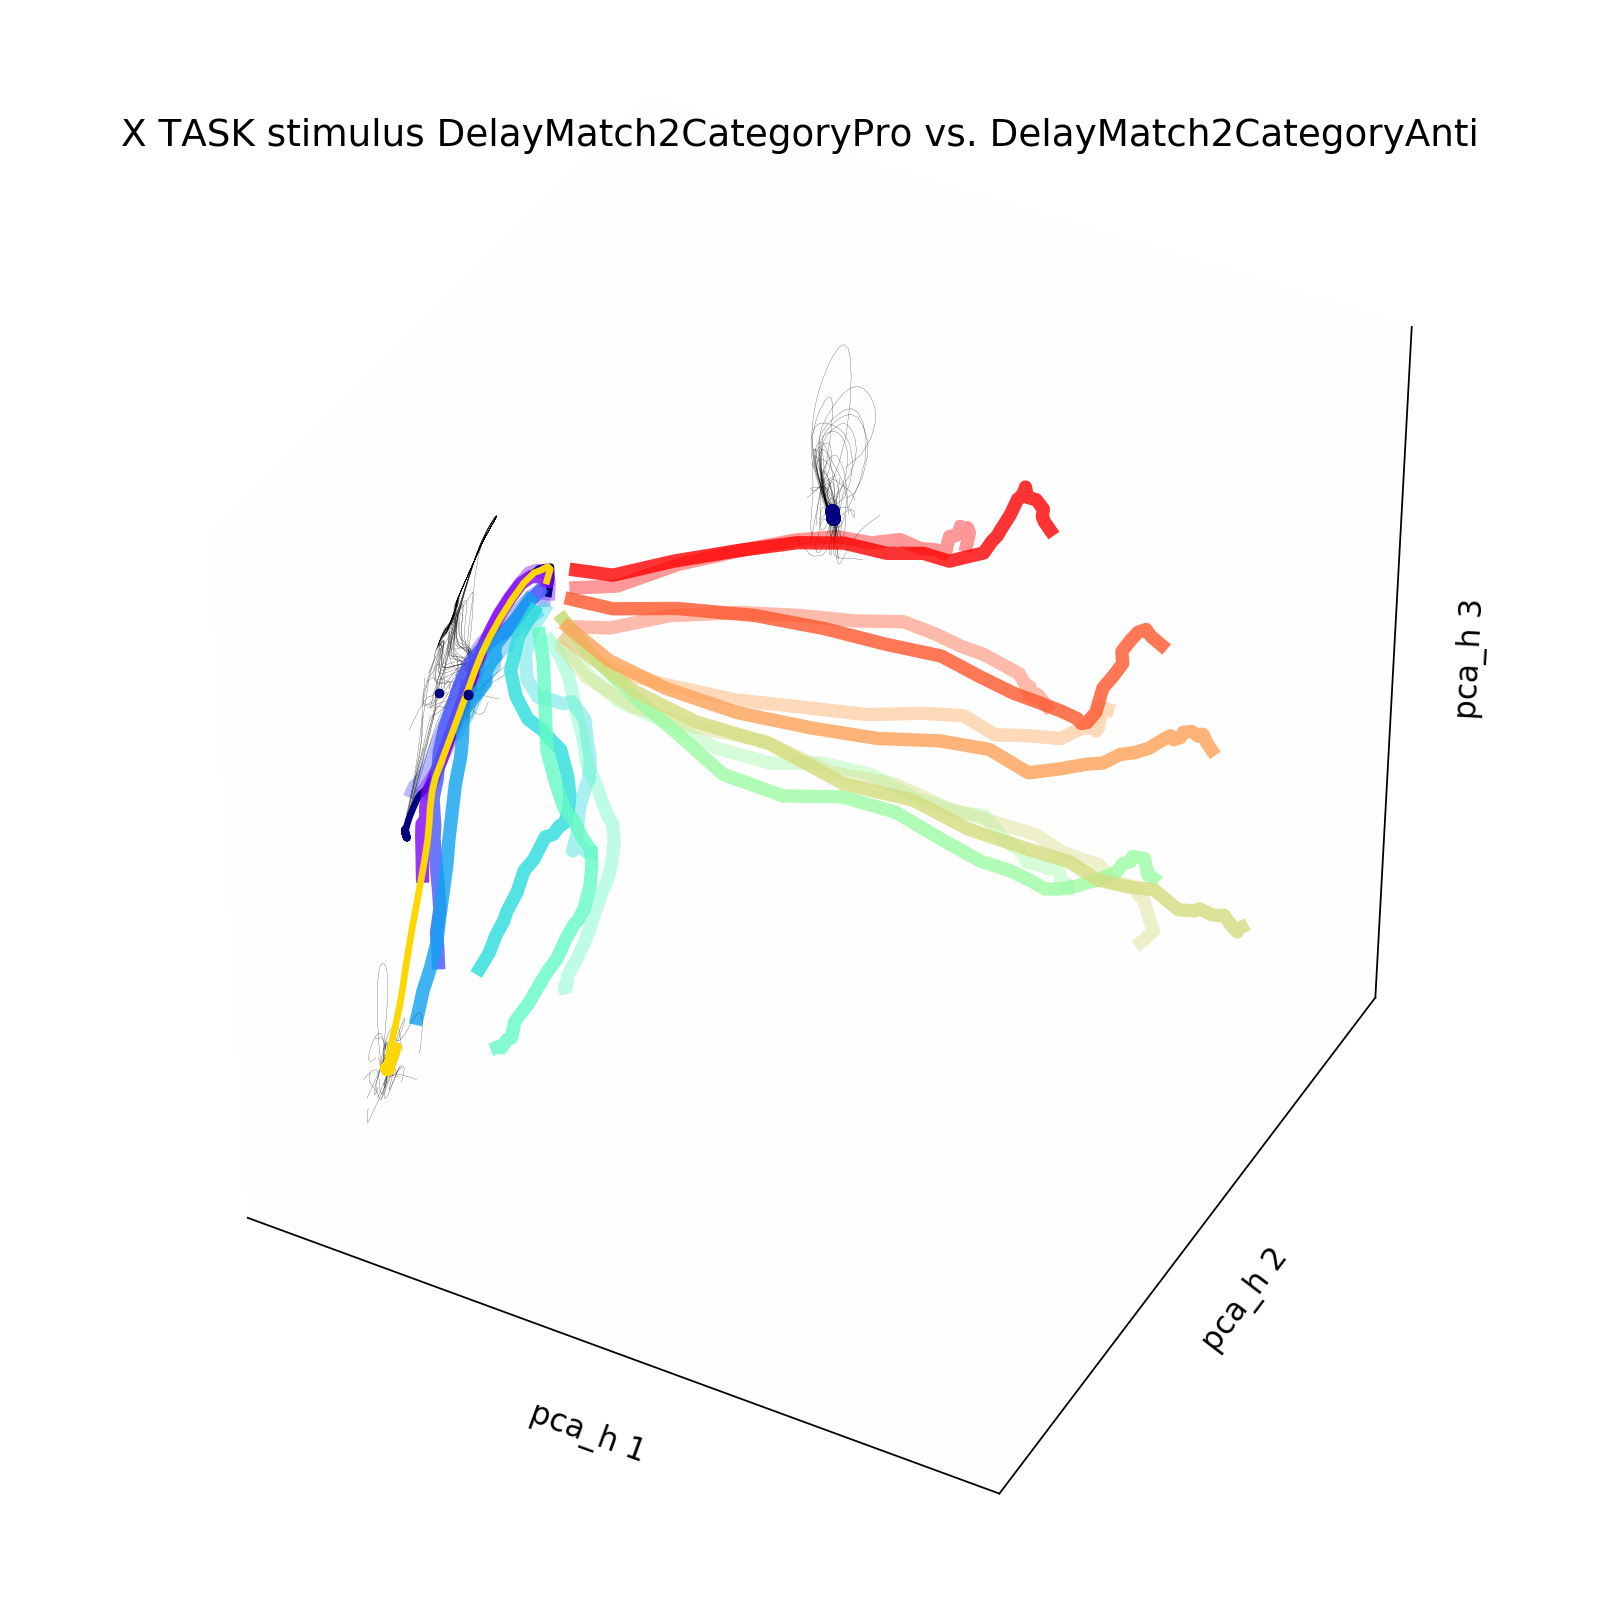

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/randgauss/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
stim1
stim1
0.15811388300841

In [107]:
########## X TASK ###########
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

ax = fig.add_subplot(111, projection='3d')
w_color = .005
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

trial_num = 0
epoch = 'stim1'
axs = 'pca_h'
c = 'orchid'
cmap=plt.get_cmap('rainbow')
linestyle = '-'
q_thresh = 1e-7
ri_set = [18,19]
n_steps = 500

ri_axs = 1
rule = rules_dict['all'][ri_set[ri_axs]]
trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule)
f = get_single_task_fp_filename(trial,epoch,trial_num)
filename = os.path.join(save_dir,f+'.npz')
# fp_struct = np.load(filename)

# D_use = make_FP_axs(filename, m, rule, epoch, axs = axs, clust = 'False')

epoch_name, rule_name1, _, _ = take_names(epoch,rules_dict['all'][ri_set[0]])
_, rule_name2, _, _ = take_names(epoch,rules_dict['all'][ri_set[1]])
axes_label1 = axs+' 1'
axes_label2 = axs+' 2'
axes_label3 = axs+' 3'

cm_set = ['navy','gold']

for ri in range(len(ri_set)):
    rule = rules_dict['all'][ri_set[ri]]

    trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
    trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/6))

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    x_t = np.matlib.repmat(trial.x[T_inds[1],trial_num,:],n_steps,1)

#     plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 6, 
#            linestyle = linestyle, alpha = .4*(ri+1))
    plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,trial_set,linewidth = 6, 
           linestyle = linestyle, alpha = .4*(ri+1))
    
    save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule)
    f = get_single_task_fp_filename(trial,epoch,trial_num)
    filename = os.path.join(save_dir,f+'.npz')
    fp_struct = np.load(filename)

    fp_inds = fp_struct['qstar'] < q_thresh
    plot_FP_jitter_3D(m,D_use,trial,trial_num,epoch,fp_struct,fp_inds,x_t,jit_fps=True,
                      rand_step_coef = 0.05,n_steps = n_steps,lw = 2,al = .3,linestyle = '-',n_jit = 20,
                      c = cm_set[ri])

tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs. '+rule_name2
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])
ax.set_xlabel(axes_label1)
ax.set_ylabel(axes_label2)
ax.set_zlabel(axes_label3)
ax.set_title(tit)
ax.view_init(elev=30, azim=-50)
plt.show()

In [121]:
os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz')

'/Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/interp_tasks/dmcgo_dmcnogo/tol_q_e_6.0/dmcgo_dmcnogo_stim1_stim1_x18.0_x18.0_step_16.npz'

In [19]:
np.sort(fp_struct['qstar'])

array([2.44449683e-09, 2.37639579e-08, 2.47516265e-08, 6.43108891e-08,
       7.43052198e-08, 1.15480447e-07, 2.03346531e-07, 2.17218314e-07,
       2.46240063e-07, 2.79583361e-07, 3.26993899e-07, 3.54545818e-07,
       3.98481689e-07, 4.79213043e-07, 5.25530481e-07, 5.34275216e-07,
       5.91217088e-07, 6.82727091e-07, 9.15831379e-07, 1.11260374e-06,
       1.28360671e-06, 1.47055414e-06, 1.78074913e-06, 1.97603913e-06,
       2.29203010e-06, 2.48989295e-06, 2.61025048e-06, 2.74411514e-06,
       3.48480535e-06, 3.80446409e-06, 4.16682451e-06, 4.22145376e-06,
       4.54743167e-06, 4.72591637e-06, 4.73194768e-06, 5.09703341e-06,
       5.31943624e-06, 5.47032596e-06, 5.49879542e-06, 5.51299127e-06,
       5.51419862e-06, 5.65081882e-06, 5.70987004e-06, 5.83274959e-06,
       5.89955152e-06, 5.98324277e-06, 6.25973280e-06, 6.30112709e-06,
       6.47306251e-06, 6.61819558e-06, 6.89083708e-06, 7.52726737e-06,
       8.58204021e-06, 9.13960776e-06, 9.14848351e-06, 9.20903676e-06,
      

In [225]:
f

'dmcnogo_dmcgo_stim1_stim1_x198.0_x198.0'

<IPython.core.display.Javascript object>


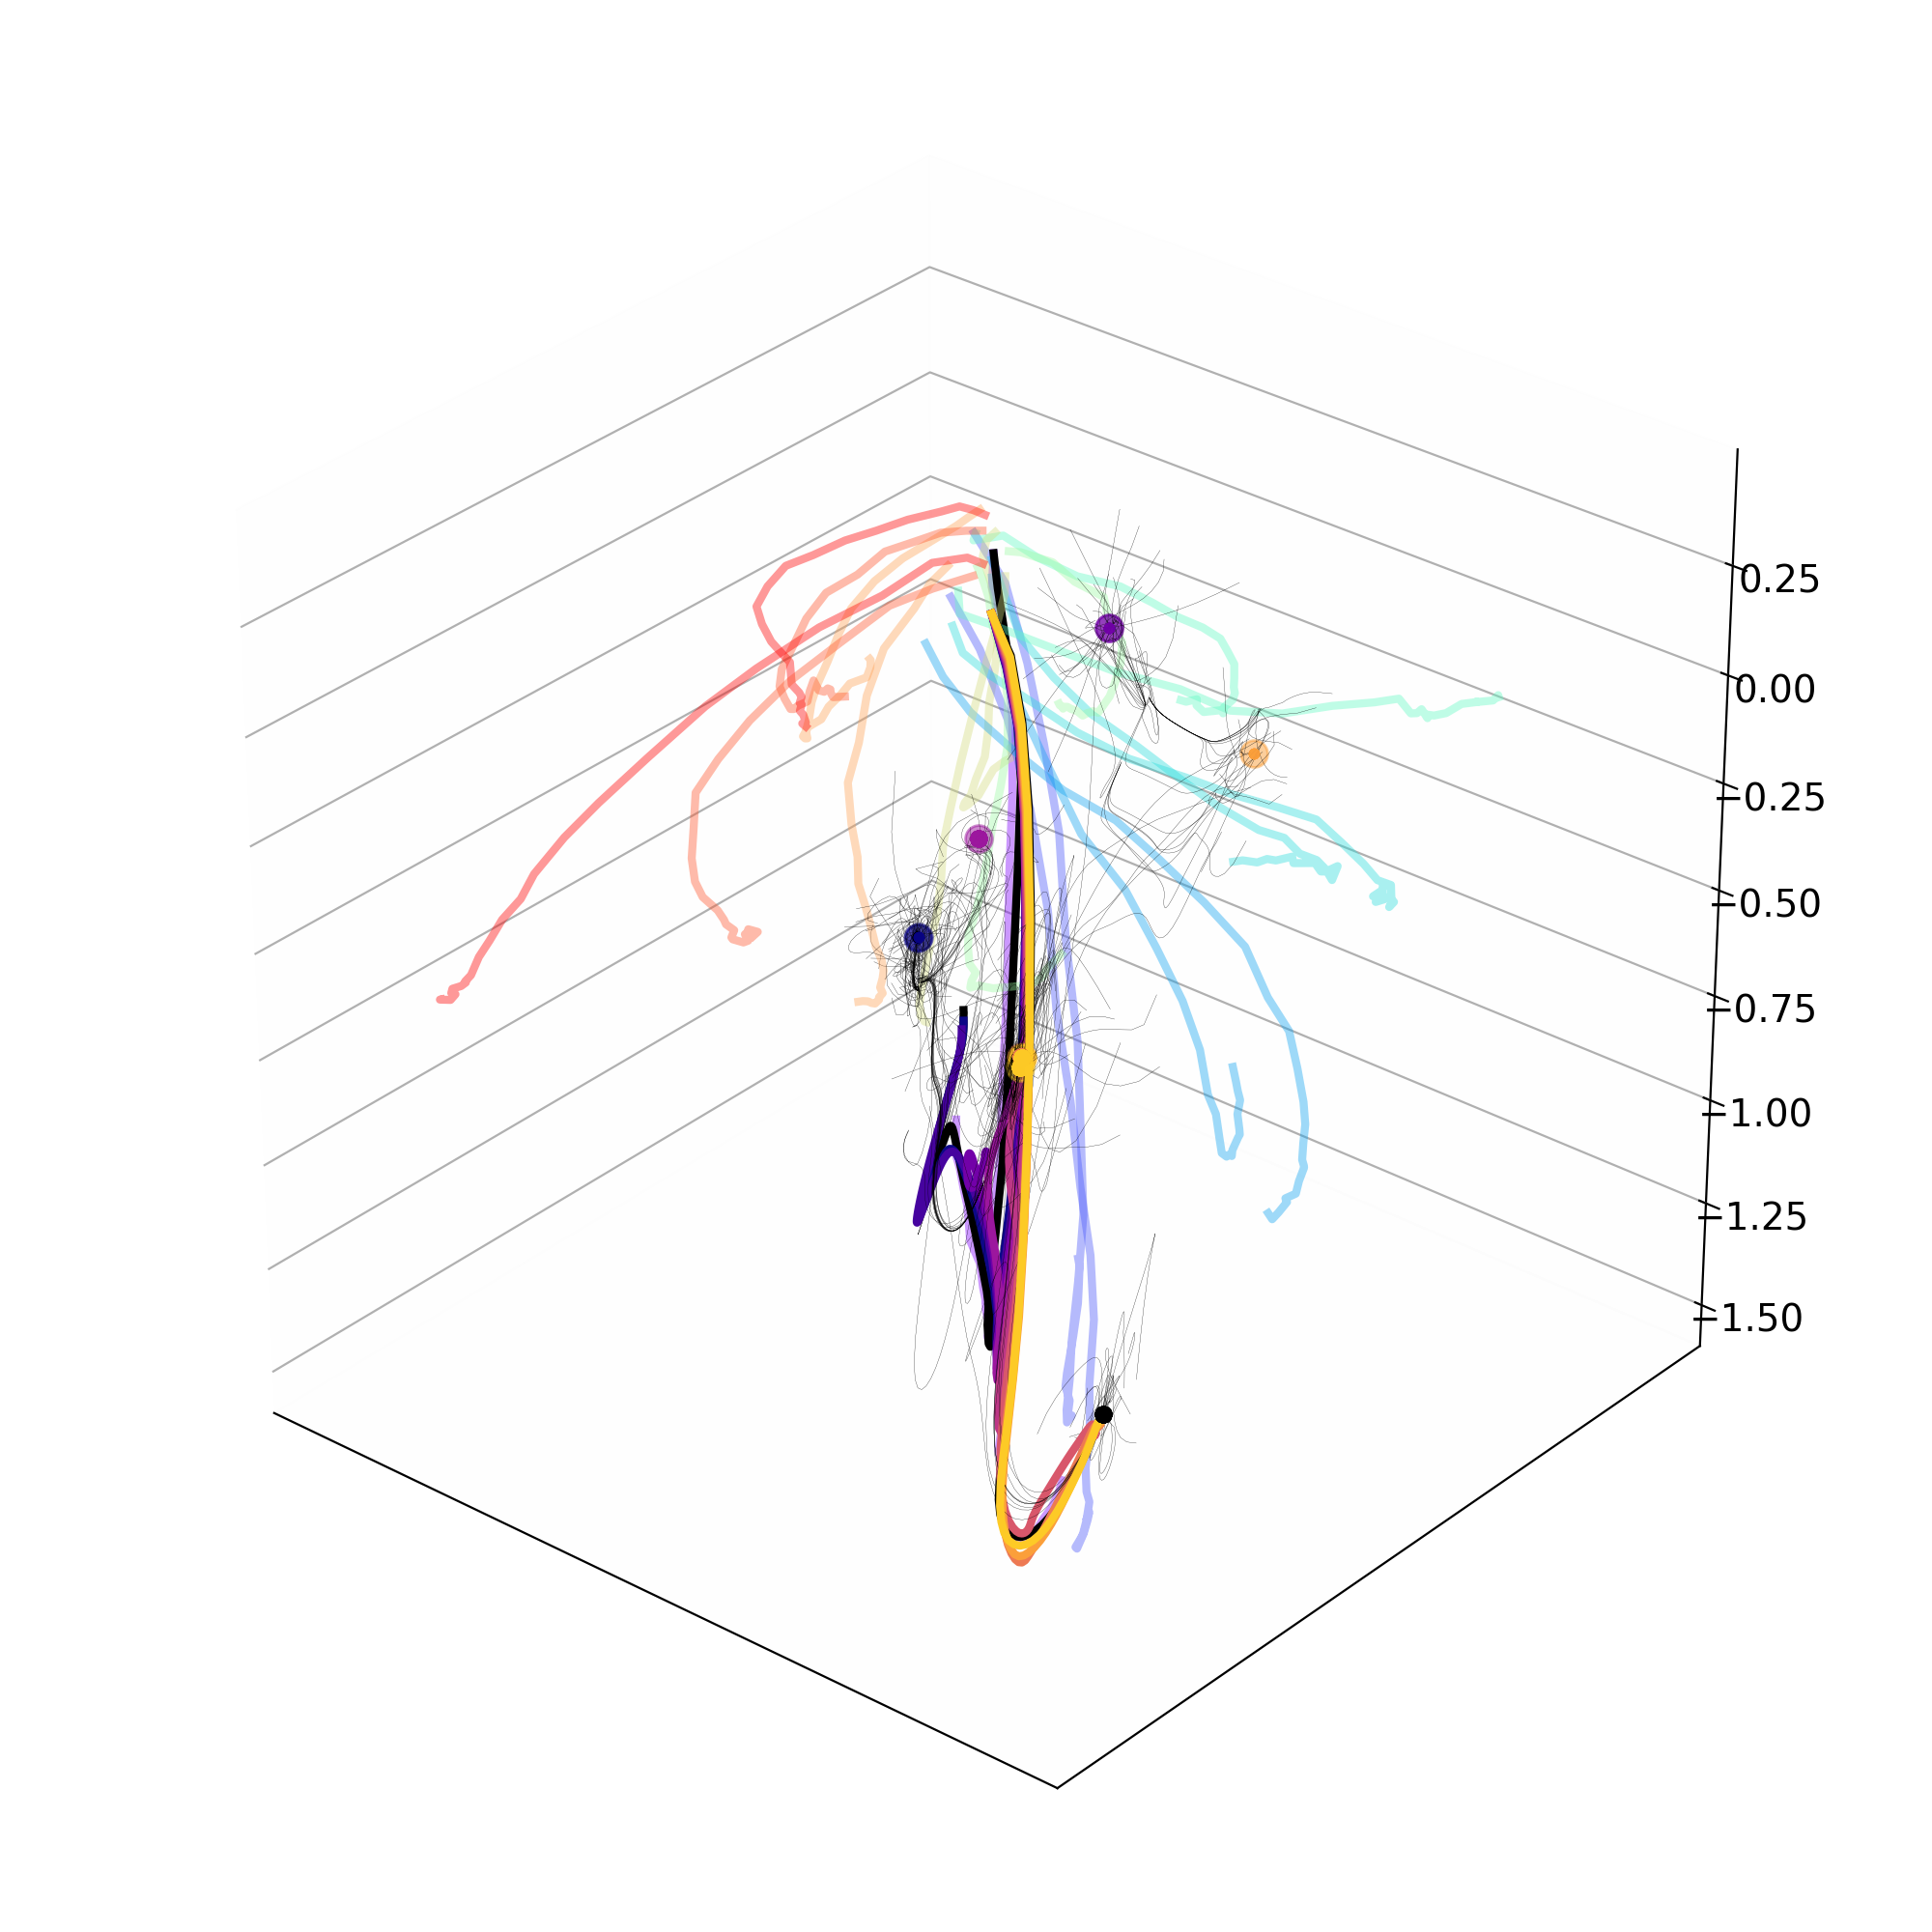

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
0.158113883008419
Variables being opti

Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/laura

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/variable_stim/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/untrained/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters f

In [245]:
########## X TASK ###########
plt.rcParams.update({'font.size': 14})
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10),tight_layout=True,facecolor='white')

ax = fig.add_subplot(111, projection='3d')
w_color = .005
ax.w_xaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_yaxis.set_pane_color ((w_color, w_color, w_color, w_color))
ax.w_zaxis.set_pane_color ((w_color, w_color, w_color, w_color))

trial_num = [0,0]
epoch_list = ['stim1','stim1']
axs = 'pca_h'
c = 'orchid'
cmap_grad = plt.get_cmap('plasma')
step_file = 'interp_tasks_small_init'
q_tol_name = 'tol_q_e_7.0'
linestyle = '-'
q_thresh = 1e-7
ri_set = [19,18]
n_interp = 9
n_steps = 100

ri_axs = 1
epoch = epoch_list[ri_axs]
rule = rules_dict['all'][ri_set[ri_axs]]
trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule)
f = get_single_task_fp_filename(trial,epoch,trial_num[ri_axs])
filename = os.path.join(save_dir,f+'.npz')
fp_struct = np.load(filename)

D_use = make_FP_axs(filename, m, rule, epoch, axs = axs, clust = 'False')

epoch_name, rule_name1, _, _ = take_names(epoch,rules_dict['all'][ri_set[0]])
_, rule_name2, _, _ = take_names(epoch,rules_dict['all'][ri_set[1]])
axes_label1 = axs+' 1'
axes_label2 = axs+' 2'
axes_label3 = axs+' 3'

rule1 = rules_dict['all'][ri_set[0]]
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, ri_set[1]) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

T_inds1 = get_T_inds(trial1,epoch_list[0])
inputs_1 = trial1.x[T_inds1[1],trial_num[0],:]
T_inds2 = get_T_inds(trial2,epoch_list[1])
inputs_2 = trial2.x[T_inds2[1],trial_num[1],:]
del_inputs = inputs_2 - inputs_1

for ri in range(len(ri_set)):
    rule = rules_dict['all'][ri_set[ri]]
    trial = gen_trials_from_model_dir(m,rule,mode='test',noise_on = False)
    trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch)
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    x_t = np.matlib.repmat(trial.x[T_inds[1],trial_num[ri],:],n_steps,1)

#     plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 6, 
#            linestyle = linestyle, alpha = .4)
    plot_N3D(ax,x_epoch[trial_set,:,:],D_use.T,trial_set,linewidth = 3, 
           linestyle = linestyle, alpha = .4)
    
    save_dir = os.path.join(m,'tf_fixed_pts_all_init',rule)
    f = get_single_task_fp_filename(trial,epoch,trial_num[ri])
    filename = os.path.join(save_dir,f+'.npz')
    fp_struct = np.load(filename)

    fp_inds = fp_struct['qstar'] < q_thresh
    plot_FP_jitter_3D(m,D_use,trial,trial_num[ri],epoch,fp_struct,fp_inds,x_t,jit_fps=True,
                      rand_step_coef = 0.05,n_steps = n_steps,lw = 3,al = .3,linestyle = '-',n_jit = 20,
                      c = 'k')
    
for step_i in range(n_interp):
    
    step_inputs = inputs_1[np.newaxis,:]+del_inputs[np.newaxis,:]*(step_i/n_interp)
    x_t = np.matlib.repmat(step_inputs,n_steps,1)

    f = get_interp_filename(trial1,trial2,epoch_list,trial_num)
    save_dir = os.path.join(m,step_file,'_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]]))
    fp_struct = np.load(os.path.join(save_dir,q_tol_name,f+'_step_'+str(step_i)+'.npz'))
    step_fps = fp_struct['xstar']
    fp_inds = fp_struct['qstar']<q_thresh

    fp_project = np.dot(step_fps[fp_inds,:],D_use)
    ax.plot3D(fp_project[:,0],fp_project[:,1],fp_project[:,2],'o',markersize = 10,
             c = cmap_grad(step_i/n_interp),alpha = .5)

    if step_i%1==0:

        plot_FP_jitter_3D(m,D_use,trial,trial_num[ri],epoch,fp_struct,fp_inds,x_t,jit_fps=True,
                          rand_step_coef = 0.1,n_steps = n_steps,lw = 1,al = .3,linestyle = '-',n_jit = 20,
                          c = cmap_grad(step_i/n_interp))

# tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
plt.xlabel('')
plt.ylabel('')
plt.title('')
ax.view_init(elev=30, azim=-50)
# ax.view_init(elev=11, azim=79) #cat

tasks_str = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])
if not os.path.exists(os.path.join(figpath,step_file,tasks_str)):
    os.makedirs(os.path.join(figpath,step_file,tasks_str))
    
figname = axes_label1+'_'+axes_label2+'_'+axes_label3+'_'+epoch+'_'+tasks_str
plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,tasks_str,figname+'.png'))
plt.show()

In [49]:
########## X TASK ###########
n_interp = 20

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = ['dmsgo','delaygo']
epoch_set = ['stim1','stim1']
step_file = 'interp_tasks'
linestyle = ['-','-']
axs = 'pca_fp'
q_str = 'tol_q_e_3.0'

trial_str = '_'.join(str(t) for t in trial_num)
rule_str = '_'.join(str(r) for r in rule_set)

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['thistle','brown']

rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rule_set[rule_axs]

# trial = gen_trials_from_model_dir(m,rule,noise_on = False)
# filename,_ = get_filename(trial,epoch,trial_num[rule_axs])
# f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
# D_use,_,_ = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
# epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
# epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])
# axes_label1 = axs+' 1'
# axes_label2 = axs+' 2'
# axes_label3 = axs+' 3'

rand_step_coef = 0
al = .3

ri_range = 1
movie_inds = 60
w_fp = 0

for im_num in range(1,movie_inds):
    fig = plt.figure(figsize=(8,8),tight_layout=True,facecolor='white')
    ax = plt.subplot(111)
    
    for ri in range(ri_range):

        rule = rule_set[ri]
        epoch = epoch_set[ri]
        c_master = cmap_discrete[ri]

        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))

        _,x = gen_X_from_model_dir(m,trial)
        T_inds = get_T_inds(trial,epoch_set[ri])
        x_epoch = np.transpose(x[:,:,T_inds[:im_num]],(1,2,0))

        ax = plt.subplot(111)
        plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 6, 
               linestyle = linestyle[ri], alpha = (ri/2)+.4, markersize = 20)

        if w_fp:
            
#             if im_num==1:
            filename,_ = get_filename(trial,epoch,trial_num[ri])
            f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
            fp_struct = np.load(f)
            fp_inds = fp_struct['qstar']<.001
            sorted_fps = fp_struct['xstar'][fp_inds,:]
            J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
            eig_decomps = comp_eig_decomp(J_xstar)
            fp_inds = range(len(eig_decomps))

            plot_FP_minimal(m,D_use,rule,trial_num[ri],epoch,sorted_fps,fp_inds,eig_decomps,[rule,],
                       rand_step_coef = rand_step_coef, al = al, linestyle = '-', n_steps = 120, 
                           n_jit = 0,c_master = c_master)

    #     for step_i in range(n_interp):

    #         f = '_'.join(rule_set)+'_'+'_'.join(epoch_set)+'_x'+str(round(t_set[0],2))+'_x'+str(round(t_set[1],2))
    #         filename = os.path.join(m,step_file,rule_set[0]+'_'+rule_set[1],q_str,f+'_step_'+str(step_i)+'.npz')
    #         fp_struct = np.load(filename)
    #         step_fps = fp_struct['xstar']
    #         fp_inds = fp_struct['qstar']<.0001

    #         fp_project = np.dot(step_fps,D_use)
    #         plt.plot(fp_project[fp_inds,0],fp_project[fp_inds,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp),alpha = .5)


    tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')
    plt.xlim((-5,13))
    plt.ylim((-8,10))
    
    if w_fp:
        movie_dir = os.path.join(figpath,step_file,epoch,'movie_dir_ri_range_'+str(ri_range)+'_wfp')
    else:
        movie_dir = os.path.join(figpath,step_file,epoch,'movie_dir_ri_range_'+str(ri_range))
        
    if not os.path.exists(movie_dir):
        os.makedirs(movie_dir)

    figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+trial_str+'_'+tit
    plt.savefig(os.path.join(movie_dir,str(im_num)+figname+'.png'))

images = []
for t in range(1,im_num):#T*xt):
    filename = os.path.join(movie_dir,str(t)+figname+'.png')
    images.append(imageio.imread(filename))
    

imageio.mimsave(movie_dir+'/movie.gif', images)

<IPython.core.display.Javascript object>

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/LeakyRNN/retanh/diag/15_tasks/256_n_rnn/l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/1/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kern

NameError: name 'figpath' is not defined

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/crystals/softplus/l2w0001/0/model.ckpt
delay1
delay1
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/dat

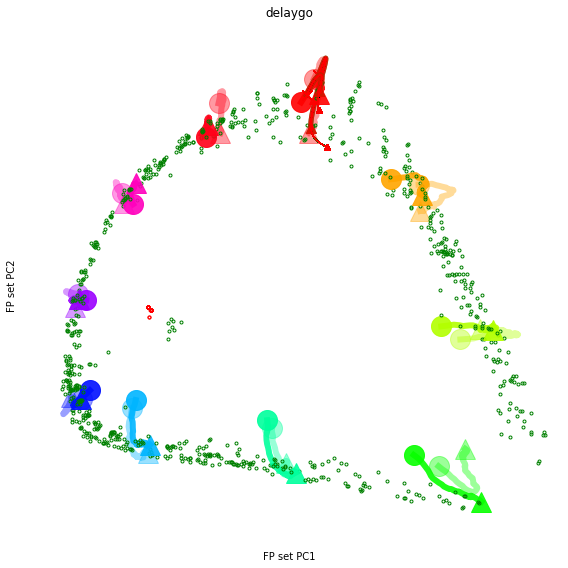

In [90]:
########## X TASK ###########

fig = plt.figure(figsize=(8,8),tight_layout=True,facecolor='white')
n_interp = 20

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = ['dmsgo','delaygo']
epoch_set = ['delay1','delay1']
step_file = 'interp_tasks'
linestyle = ['-','-']
axs = 'pca_fp'
q_str = 'tol_q_e_3.0'

trial_str = '_'.join(str(t) for t in trial_num)
rule_str = '_'.join(str(r) for r in rule_set)

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['navy','gold']

rule_axs = 1
epoch = epoch_set[rule_axs]
rule = rule_set[rule_axs]

trial = gen_trials_from_model_dir(m,rule,noise_on = False)
filename,_ = get_filename(trial,epoch,trial_num[rule_axs])
f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
D_use,_,_ = make_FP_axs(f, m, rule, epoch, axs = axs, clust = 'False')
epoch_name, rule_name1, _, _ = take_names(epoch,rule_set[0])
epoch_name, rule_name2, _, _ = take_names(epoch,rule_set[1])
axes_label1 = axs+' 1'
axes_label2 = axs+' 2'
axes_label3 = axs+' 3'

rand_step_coef = 0
al = .3

for ri in range(2):
    
    rule = rule_set[ri]
    epoch = epoch_set[ri]
    c_master = cmap_discrete[ri]
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    trial_set = range(0,np.shape(trial.x)[1],int(np.shape(trial.x)[1]/10))
    
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[ri])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    
    ax = plt.subplot(111)
    plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 6, 
           linestyle = linestyle[ri], alpha = (ri/2)+.4, markersize = 20)
    
    filename,_ = get_filename(trial,epoch,trial_num[ri])
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,filename+'.npz')
    fp_struct = np.load(f)
    fp_inds = fp_struct['qstar']<.0001
    sorted_fps = fp_struct['xstar'][fp_inds,:]
    J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
    eig_decomps = comp_eig_decomp(J_xstar)
    fp_inds = range(len(eig_decomps))
    
    plot_FP_jitter(m,D_use,rule,trial_num[ri],epoch,sorted_fps,fp_inds,eig_decomps,[rule,],
               rand_step_coef = rand_step_coef, al = al, linestyle = '-', n_steps = 120, 
                   n_jit = 0,c_master = 'g')
    
    f = os.path.join(m,'lesion_fps_hierarchical_ward_max_d3/tf_fixed_pts_lesion_13/',rule,'delay1_0.0.npz')
    fp_struct = np.load(f)
    fp_inds = fp_struct['qstar']<.0001
    sorted_fps = fp_struct['xstar'][fp_inds,:]
#     J_xstar = fp_struct['J_xstar'][fp_inds,:,:]
#     eig_decomps = comp_eig_decomp(J_xstar)
    fp_inds = range(len(sorted_fps))
    
    plot_FP_jitter(m,D_use,rule,trial_num[ri],epoch,sorted_fps,fp_inds,eig_decomps,[rule,],
           rand_step_coef = rand_step_coef, al = al, linestyle = '-', n_steps = 120, 
               n_jit = 0,c_master = 'r')

tit = 'X TASK ' + epoch_name +' '+rule_name1+' vs.'+rule_name2
# plt.title(tit,fontsize = 18)
# plt.xlabel(axes_label1,fontsize = 18)
# plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
plt.xlim((-5,13))
plt.ylim((-8,10))

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
    
# figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+trial_str+'_'+tit
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

In [ ]:
########## X EPOCH ###########

fig = plt.figure(figsize=(6,6),tight_layout=True,facecolor='white')
t_set = [0,0]
trial_num = [0,0]
trial_set = range(0,80,10)
rule_set = ['delaygo',]
epoch_set = ['stim1','delay1']
step_file = 'interp_epochs'
linestyle = ['-','--']
axs ='pca'

ri = 0
rule = rule_set[ri]
epoch_axs = 0

f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch_set[epoch_axs]+'_'+str(t_set[epoch_axs])+'.0.npz')
D_use,_,_ = make_FP_axs(f,m,rule,epoch_set[epoch_axs],axs =axs, clust = 'False')
epoch_name1, rule_name1, _, _ = take_names(epoch_set[0],rule_set[0])
epoch_name2, rule_name2, _, _ = take_names(epoch_set[1],rule_set[0])
axes_label1 = axs + ' 1'
axes_label2 = axs + ' 2'

# use_yinds = [4,5]
# axes_label1 = Y_labels[use_yinds[0]]
# axes_label2 = Y_labels[use_yinds[1]]

# D_use = Beta_qr[:,use_yinds]
# D_use[:,1] = w_out[:,2]
# axes_label2 = 'sin out'

cmap_grad = plt.get_cmap('plasma')
cmap_discrete = ['navy','gold']

for ei in range(len(epoch_set)):
    ax = plt.subplot(111)
    
    epoch = epoch_set[ei]
    f = os.path.join(m,'tf_fixed_pts_all_init',rule,epoch+'_'+str(t_set[ri])+'.0.npz')
    fp_struct = np.load(f)
    sorted_fps = fp_struct['xstar']
    qvals = fp_struct['qstar']
    fp_project = np.dot(sorted_fps,D_use)
#     print(np.log10(qvals))
    
    stable_fp = np.log10(qvals)<-6
    plt.plot(fp_project[stable_fp==1,0],fp_project[stable_fp==1,1],'o',c = cmap_discrete[ei],
             markersize = 10, alpha = 1, linewidth = 2)
    plt.plot(fp_project[stable_fp==0,0],fp_project[stable_fp==0,1],'o',c = cmap_discrete[ei],
             markersize = 10, markerfacecolor = 'none', alpha = 1, linewidth = 2)
    
#     _,x = gen_X_from_model_dir(m,trial)
#     T_inds = get_T_inds(trial,epoch)
#     x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
#     plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 2, linestyle = linestyle[ei])
    
    trial = gen_trials_from_model_dir(m,rule,noise_on = False)
    _,x = gen_X_from_model_dir(m,trial)
    T_inds = get_T_inds(trial,epoch_set[1])
    x_epoch = np.transpose(x[:,:,T_inds],(1,2,0))
    plot_N(x_epoch[trial_set,:,:],D_use.T,trial.y_loc[-1,trial_set],linewidth = 10, 
           linestyle = linestyle[ri], alpha = .1)
    
    plot_FP_jitter_2D(m,D_use,rule,trial_num[ei],epoch,sorted_fps,range(len(sorted_fps)),qvals,
              rand_step_coef = 0.1, al = 1, linestyle = linestyle, n_steps = 50,
              n_jit = 1,unstable_qlim = -10,c = cmap_discrete[ei])

    for step_i in range(20):
        f = rule_set[0]+'_'+epoch_set[0]+'_'+epoch_set[1]+'_'+str(t_set[ri])+'_step_'+str(step_i)
        filename = os.path.join(m,step_file,rule_set[0],f+'.npz')
        fp_struct = np.load(filename)
        step_fps = fp_struct['xstar']
#         print(len(step_fps))

        fp_project = np.dot(step_fps,D_use)
        plt.plot(fp_project[:,0],fp_project[:,1],'.',markersize = 5,c = cmap_grad(step_i/n_interp))
        
tit = 'X EPOCH ' + epoch_set[0]+' vs. '+epoch_set[1]
plt.title(tit,fontsize = 18)
plt.xlabel(axes_label1,fontsize = 18)
plt.ylabel(axes_label2,fontsize = 18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

if not os.path.exists(os.path.join(figpath,step_file)):
    os.makedirs(os.path.join(figpath,step_file))
figname = axes_label1+'_'+axes_label2+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
# figname = axs+'_'+rule+'_'+epoch+'_'+str(t_set[0])+'_'+tit
plt.savefig(os.path.join(figpath,step_file,figname+'.pdf'))
plt.savefig(os.path.join(figpath,step_file,figname+'.png'))
plt.show()

In [46]:
os.path.join(figpath,step_file,figname+'.pdf')

'/Users/lauradriscoll/Documents/code/overleaf/multitask-nets/v1_figs/figure3/interp_epochs/pca 1_pca 2_delaygo_delay1_0_X EPOCH stim1 vs. delay1.pdf'